Funktioniert und nachvollziehbar (Quelle: https://www.kaggle.com/code/syedjaferk/imdb-sentiment-classification-using-naive-bayes/notebook)

To-Does:
 - Imports müssen nochmal gecheckt werden welche wirklich gebraucht werden
 - Code muss auskommentiert werden

In [1]:
import re
import string
import pandas as pd
import nltk
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from string import punctuation
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from bs4 import BeautifulSoup
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


c:\Users\User\OneDrive - METRO\Desktop\Uni\Dis25 - Haak\Exam\dis25_nlp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load the IMDb reviews dataset
data = tfds.load('imdb_reviews', split={'train': 'train', 'test': 'test'})

In [3]:
# Convert the data into pandas DataFrame and decode bytes to string
train_df = tfds.as_dataframe(data['train'])
test_df = tfds.as_dataframe(data['test'])

train_df['text'] = train_df['text'].apply(lambda x: x.decode('utf-8'))
test_df['text'] = test_df['text'].apply(lambda x: x.decode('utf-8'))

train_df['label'] = train_df['label'].replace({0: 'negative', 1: 'positive'})
test_df['label'] = test_df['label'].replace({0: 'negative', 1: 'positive'})

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(train_df, train_df['label'], test_size=0.2, random_state=42, stratify=train_df['label'])

In [4]:
# Label encoding for the sentiment labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(20000, 2) (20000,)
(5000, 2) (5000,)


# Data Cleaning

In [6]:
spell = SpellChecker()
lemmatizer = WordNetLemmatizer()

# Way better runtime!
cachedStopWords = stopwords.words("english")


def transformations(dataframe):
    # HTML Tags removal
    dataframe['text'] = dataframe['text'].apply(lambda words: re.sub('<[^<]+?>', '', words))
    print("HTML Done")

    # Lower case conversion
    dataframe['text'] = dataframe['text'].apply(lambda words: words.lower())
    print("Lower Done")

    # Word Tokenization
    dataframe['text'] = dataframe['text'].apply(word_tokenize)
    print("Tokenization Done")

    # Punctuation removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if not x in punctuation])
    print("Punctuation Done")

    # Number removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if not x.isdigit()])
    print("Number Done")

    # # Frequent word removal
    # temp = dataframe['text'].apply(lambda words: " ".join(words))
    # freq = pd.Series(temp).value_counts()[:10]
    # dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if x not in freq.keys()])

    # Stopword removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if x not in cachedStopWords])
    print("Stopword Done")

    # Lemmatization
    dataframe['text'] = dataframe['text'].apply(lambda words: [lemmatizer.lemmatize(x) for x in words])
    print("Lemmatization Done")

    # Join again
    dataframe['text'] = dataframe['text'].apply(lambda words: " ".join(words))

    return dataframe

In [7]:
x_train = transformations(x_train)

HTML Done


Lower Done
Tokenization Done
Punctuation Done
Number Done
Stopword Done
Lemmatization Done


In [8]:
x_test = transformations(x_test)

HTML Done
Lower Done
Tokenization Done
Punctuation Done
Number Done
Stopword Done
Lemmatization Done


In [9]:
x_train.head()

,label,text
15072,positive,latest film spanish director agusti villaronga...
9987,negative,others mentioned movie similar fly version les...
24558,positive,idea describe movie also would love provide ot...
2571,positive,ah loved movie think made laugh loud dozen tim...
16059,positive,brilliant movie drawing amazing bad ended begu...


# Vectorizer

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
vec = vec.fit(x_train.text)
train_x_bow = vec.transform(x_train.text)
test_x_bow = vec.transform(x_test.text)

In [11]:
print(train_x_bow.shape)
print(test_x_bow.shape)

(20000, 64138)
(5000, 64138)


# Naive Bayes with Hyperparameter Tuning

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [13]:
classifier = MultinomialNB()

In [14]:
alpha_ranges = {
    "alpha": [0.001, 0.01, 0.1, 1, 10.0, 100]
}

In [15]:
grid_search = GridSearchCV(classifier, param_grid=alpha_ranges, scoring='accuracy', cv=2, return_train_score=True)
grid_search.fit(train_x_bow, y_train)

GridSearchCV(cv=2, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10.0, 100]},
             return_train_score=True, scoring='accuracy')

In [16]:
best_classifier = grid_search.best_estimator_

# classifier = MultinomialNB(alpha=1)
# classifier.fit(train_x_bow, y_train)

In [17]:
alpha = [0.001, 0.01, 0.1, 1, 10.0, 100]
train_acc = grid_search.cv_results_['mean_train_score']
train_std = grid_search.cv_results_['std_train_score']

test_acc = grid_search.cv_results_['mean_test_score']
test_std = grid_search.cv_results_['std_test_score']

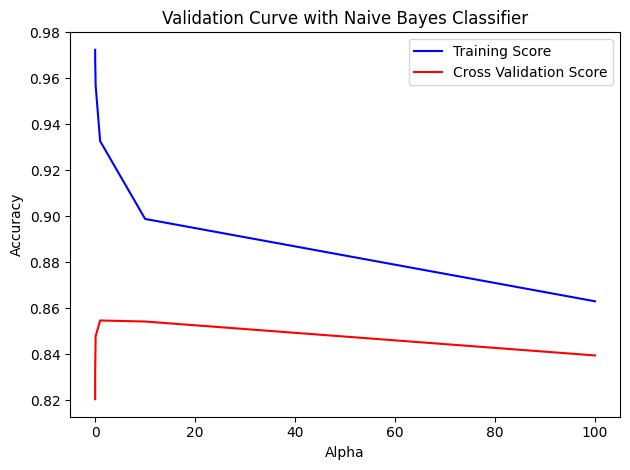

In [18]:
import matplotlib.pyplot as plt

plt.plot(alpha, train_acc, label="Training Score", color='b')
plt.plot(alpha, test_acc, label="Cross Validation Score", color='r')

plt.title("Validation Curve with Naive Bayes Classifier")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.legend(loc = 'best')
plt.show()


In [19]:
predict = best_classifier.predict(test_x_bow)

In [20]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(y_test, predict))

Accuracy is  0.8586


In [21]:
from sklearn.metrics import classification_report
print("Accuracy is ", classification_report(y_test, predict))

Accuracy is                precision    recall  f1-score   support

           0       0.85      0.87      0.86      2500
           1       0.87      0.84      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [22]:
from joblib import dump
dump(vec, 'vectors.naive_bayes')
dump(best_classifier, 'classifier.naive_bayes')

['classifier.naive_bayes']